# Excercises 1

UW Geospatial Data Analysis  
CEE498/CEWA599  
David Shean  

## Objectives
* Learn how to inspect, read and write raster data
* Develop a more intuitive understanding of raster transforms, window/extent operations
* Understand raster visualization approaches, contrast stretching and interpolation settings
* Perform common raster band math operations (e.g., NDVI) using NumPy
* Perform quantitative raster analysis using value thresholds and binary masks
* Understand programmtic Landsat-8 archive access and download

## Tools
* GDAL
* Rasterio
* NumPy
* Matplotlib

# Landsat
* Hopefully you've all seen or used Landsat imagery at some point in the past
* Take a few minutes to refresh your memory: https://www.usgs.gov/land-resources/nli/landsat
* There is a huge amount of information out there on the Landsat missions, data products, science results

# Landsat-8
* Landsat-8 is the mission (a satellite)
    * Operatioinial Land Imager (OLI) is an instrument (a camera)
    * Thermal Infrared Sensor (TIRS) is an insitrument (also a camera, but measures thermal infrared radiation, surface temperature)

Take a look at useful info here: https://www.usgs.gov/land-resources/nli/landsat/landsat-8

## Summary: Orbit and Data collection
Landsat 8 orbits the the Earth in a sun-synchronous, near-polar orbit, at an altitude of 705 km (438 mi), inclined at 98.2 degrees, and completes one Earth orbit every 99 minutes.  The satellite has a 16-day repeat cycle with an equatorial crossing time: 10:00 a.m. +/- 15 minutes.  

Landsat 8 aquires about 740 scenes a day on the Worldwide Reference System-2 (WRS-2) path/row system, with a swath overlap (or sidelap) varying from 7 percent at the equator to a maximum of approximately 85 percent at extreme latitudes. A Landsat 8 scene size is 185 km x 180 km (114 mi x 112 mi). 

## Instruments and Bands 
Focal plane: https://www.usgs.gov/media/images/landsat-8-oli-and-landsat-7-etm-focal-plane-layouts

![LS8 band table](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/Landsat%208%20band%20designations.jpg)

So, Landsat-8 sensor is the top row of colored bands in the following figure (lower rows are for older Landsat sensors):

![LS8 bands](https://landsat.usgs.gov/sites/default/files/images/MSS-thru-L9-wavelengths.jpg)

For comparison with previous Landsat missions: https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products

### Dynamic Range
* LS8 OLI provides 12-bit dynamic range: https://landsat.usgs.gov/how-does-landsat-8s-12-bit-data-improve-data-products
    * Remember, each bit is a 0 or 1.  We have 12 of them, so we have 2^12 (or 4096) unique combinations to represent brightness in the image.
* Most data types on a computer are in multiples of 8-bit bytes.  For example, a typical image of a cat face contains three 8-bit channels for red, green and blue values. 
* LS8 offers a considerable improvement over for the 8-bit dynamic range of Landsat 1-7. Improved signal to noise performance enables improved characterization of land cover state and condition.
* We don't have a convenient mechanism to store 12-bit data, so the LS8 images are stored as 16-bit unsigned integers (2^16 possible values, 0-65535)

### Image Resolution - Ground Sample Distance (GSD)
* PAN band (8) has 15 m ground sample distance (GSD)
* Multispectral (MS) bands are 30 m GSD
* Thermal IR are 100 m GSD, but are often oversampled to match MS bands

## Landsat-8 Data Products

The standard data products are "Level 1" images: they radiometrically corrected and orthorectified (terrain corrected) in the approprate UTM projection: https://www.usgs.gov/core-science-systems/nli/landsat/landsat-level-1-processing-details

For more sophisticated analysis, you typically want to use higher-level, calibrated/corrected products ("level 2" like surface reflectance values), often considered "Analysis Ready Data (ARD)": https://www.usgs.gov/land-resources/nli/landsat/landsat-science-products

### Path/Row system
* https://landsat.gsfc.nasa.gov/the-worldwide-reference-system/
* Use descending for daytime imagery
* Seattle and Mt. Rainier: path 46, row 27

### LS8 Data availability

USGS/NASA hosts the official Landsat products:
* https://earthexplorer.usgs.gov/

This option is great for one-off interactive data searches, but can be clunky and requires a lot of manual steps. Both Google and Amazon mirror the entire USGS archive, and provide a much more efficient API (application programming interface) to access the data.  This is especially important when you need to access 100s-1000s of images.

Google:
* https://cloud.google.com/storage/docs/public-datasets/landsat

Amazon Web Services (AWS): 
* https://docs.opendata.aws/landsat-pds/readme.html
* https://registry.opendata.aws/landsat-8/

In [1]:
import os
import urllib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from osgeo import gdal
import rasterio as rio
import rasterio.plot

In [3]:
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar

In [4]:
#We want to use interactive plotting for zoom/pan and live coordinate display
#%matplotlib widget
%matplotlib inline

## Finding cloud-free imagery
* Can use EarthExplorer for visual queries: https://earthexplorer.usgs.gov/
    * Get the image ID
    * Can also directly download products from EarthExplorer, but pretty inefficient
* There are automated ways to query the archives from Python API or command-line, using packages or SpatioTemporal Asset Catalog (STAC): https://landsat.stac.cloud
* For now, let's just use pre-identified images for WA state

## Download some sample imagery for faster analysis (though we could access dynamically)
* Note that transfer rates from Google Cloud should be excellent, as we're running this Jupyterhub on a Google Cloud Platform (GCP) server
* Notes about LS filenames: https://gisgeography.com/landsat-file-naming-convention/

In [5]:
#Create local directory to store images
imgdir = 'LS8_sample'
if not os.path.exists(imgdir):
    os.makedirs(imgdir)

In [27]:
#Use Google Cloud archive
base_url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01'

#Define Landsat path/row for Western Washington
path = 46
row = 27

#Pre-identified cloud-free Image IDs for this path/row 
#Summer 2018
img_id1 = 'LC08_L1TP_046027_20180818_20180829_01_T1'
#Winter 2018
img_id2 = 'LC08_L1TP_046027_20181224_20190129_01_T1'

img_list = (img_id2, img_id1)
#img_list = (img_id1,)

In [28]:
#Loop through all selected images and all bands
for img in img_list:
    for b in range(1,12):
        #Generate the appropriate URL for the images we identified
        image_url =  '{0}/{1:03d}/{2:03d}/{3}/{3}_B{4}.TIF'.format(base_url, path, row, img, b)
        print(image_url)
        #Local filename
        out_fn = os.path.join(imgdir, os.path.split(image_url)[-1])
        #Check to see if file already exists
        if not os.path.exists(out_fn):
            print("Saving:", out_fn)
            #Download the file
            urllib.request.urlretrieve(image_url, out_fn)

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B1.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B2.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B3.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B4.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B5.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B6.TIF
https://storage.googleapis.com/gcp-publi

## Do a quick `ls -lh` on the local image directory
* Note relative file sizes for the different bands of each image
    * B8 vs B3 vs. B10
    * Revisit the chart above - does this make sense for resolution of these bands?

In [29]:
!ls -lh $imgdir

total 1.8G
-rw-rw-r-- 1 jovyan users  59M Feb  1 07:06 LC08_L1TP_046027_20180818_20180829_01_T1_B1.TIF
-rw-rw-r-- 1 jovyan users  61M Feb  1 07:07 LC08_L1TP_046027_20180818_20180829_01_T1_B10.TIF
-rw-rw-r-- 1 jovyan users  58M Feb  1 07:07 LC08_L1TP_046027_20180818_20180829_01_T1_B11.TIF
-rw-rw-r-- 1 jovyan users  60M Feb  1 07:06 LC08_L1TP_046027_20180818_20180829_01_T1_B2.TIF
-rw-rw-r-- 1 jovyan users  64M Feb  1 07:06 LC08_L1TP_046027_20180818_20180829_01_T1_B3.TIF
-rw-rw-r-- 1 jovyan users  67M Feb  1 07:06 LC08_L1TP_046027_20180818_20180829_01_T1_B4.TIF
-rw-rw-r-- 1 jovyan users  85M Feb  1 07:06 LC08_L1TP_046027_20180818_20180829_01_T1_B5.TIF
-rw-rw-r-- 1 jovyan users  85M Feb  1 07:06 LC08_L1TP_046027_20180818_20180829_01_T1_B6.TIF
-rw-rw-r-- 1 jovyan users  79M Feb  1 07:06 LC08_L1TP_046027_20180818_20180829_01_T1_B7.TIF
-rw-rw-r-- 1 jovyan users 257M Feb  1 07:07 LC08_L1TP_046027_20180818_20180829_01_T1_B8.TIF
-rw-rw-r-- 1 jovyan users  43M Feb  1 07:07 LC08_L1TP_046027_201808

## Use `gdalinfo` command to get some basic information about one of the files
* Review output with your neighbor/group
    * 🤔 Talk about what each line means, if there is something you don't understand, ask!  Or look it up together!

In [30]:
sample_fn = os.path.join(imgdir, img+'_B1.TIF')
print(sample_fn)

LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B1.TIF


In [31]:
!gdalinfo $sample_fn

Driver: GTiff/GeoTIFF
Files: LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B1.TIF
Size is 7781, 7881
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1

## Specify filenames for specific bands used for later examples

In [32]:
#Specify filenames for different bands we will need for the lab
#Check table from background section to see wavelengths of each band number

#Red
r_fn = os.path.join(imgdir, img+'_B4.TIF')
#Green
g_fn = os.path.join(imgdir, img+'_B3.TIF')
#Blue
b_fn = os.path.join(imgdir, img+'_B2.TIF')
#Near-Infrared
nir_fn = os.path.join(imgdir, img+'_B5.TIF')
#Shortwave-Infrared
swir_fn = os.path.join(imgdir, img+'_B6.TIF')
#Panchromatic
p_fn = os.path.join(imgdir, img+'_B8.TIF')

# GDAL Python API basics
* I'm including this for reference
    * It's not that complicated, even though rasterio is the more popular option for Python these days (partly because of much better documentation)
* https://gdal.org/user/raster_data_model.html
* https://github.com/OSGeo/gdal/tree/master/gdal/swig/python/samples
* https://pcjericks.github.io/py-gdalogr-cookbook/index.html

In [33]:
#Open the green band GeoTiff as GDAL Dataset object
ds = gdal.Open(g_fn)

In [34]:
#Get the raster band
gdal_b = ds.GetRasterBand(1)
#Read into array
a = gdal_b.ReadAsArray()

In [35]:
#Inspect the array
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

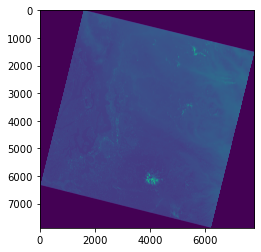

In [36]:
#View the array
f, ax = plt.subplots()
ax.imshow(a);

In [37]:
#Set array to None (frees up RAM) and close GDAL dataset
a = None
ds = None

# Rasterio basics
* We'll stick with rasterio for most of our Python raster analysis 
* https://rasterio.readthedocs.io/en/stable/quickstart.html

## Note that we can open an image directly from a url
(look Ma, no downloads!)  
Let's use the last url from our earlier download as a test

In [38]:
print(image_url)

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B11.TIF


## Use a Python `with` construct to cleanly open, inspect, and close the file directly from the url
* The Python `with` construct may be new, or maybe you used it during Lab02 when opening a text file for reading/writing.
* It is "used in exception handling to make the code cleaner and much more readable. It simplifies the management of common resources like file streams."
    * Enables more elegant file opening/closing and handling errors (like missing files)
* Let's use the `with rio.open()` approach to print out the rasterio dataset profile, without actually reading the underlying image data
    * We will temporarily store the rasterio dataset with variable name `src` (short for "source")

In [39]:
with rio.open(image_url) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [40]:
#Note that the dataset does not remain open!
src

<closed DatasetReader name='https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B11.TIF' mode='r'>

## Can also open dataset with rasterio for persistence and interactive access
* This is likely a better option as you're learning, as you can access the opened dataset and arrays you've already read in other cells
* Remember to close the rasterio dataset later!

In [41]:
src = rio.open(image_url)

In [42]:
src

<open DatasetReader name='https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B11.TIF' mode='r'>

In [43]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

### Let's use the convenient rasterio `show()` function to plot

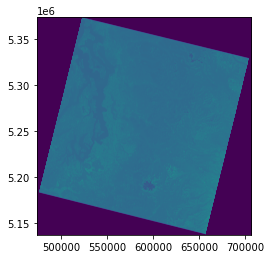

<AxesSubplot:>

In [44]:
rio.plot.show(src)

### Read the array and plot with matplotlib
* Note coordinates

In [45]:
a = src.read(1)

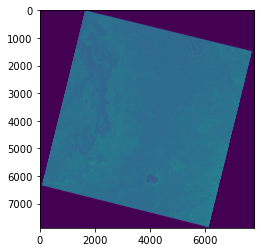

In [46]:
f,ax = plt.subplots()
ax.imshow(a);

In [47]:
#Delete array from memory
a = None
#Close the dataset
src.close()

# Part 1: Raster basics

## Open the downloaded image from disk
* Since we already downloaded these images locally, let's just open a local file
* Let's use of the red band (B4) TIF file
    * We already defined the `r_fn` above, so this should be easy

## What is the CRS of the dataset?
* Look familiar?  The `fiona` functionality underlying `rasterio` (also used by `geopandas`) was mostly written by the same author (Sean Gilles, https://github.com/sgillies). 
* If you don't recognize it by now, take a minute to look up this EPSG code

## What is the raster extent (bounds) of the dataset in projected coordinates?
* Note that this is not a simple python `list` object, but a special rasterio [`BoundingBox` object](https://rasterio.readthedocs.io/en/latest/api/rasterio.coords.html#rasterio.coords.BoundingBox) with attributes for `left`, `bottom`, etc.
    * This helps you avoid mixing up order of values that correspond to `(min_x, min_y, max_x, max_y)`
    * Note that other API and utilities may use different order (e.g., `min_x, max_x, min_y, max_y`)

## How many bands are there in this dataset?

## Review the profile and metadata record
* Inspect the rasterio `profile` and `meta` attributes, which should return dictionaries for all metadata

## OK, let's read the raster data into a NumPy array and preview
* Store the output in a new variable called `r`
* What band number do you need to use here? 
    * This dataset is for the red Landsat multispectral band, which is band #4 (B4)
    * But each band is stored as a separate TIF file (remember your dataset band `count` attribute)
    * So using rasterio `read`, which band do you need to load?

## What are the dimensions of the NumPy array?  
* Compare this with the rasterio dataset `width` and `height` attributes
    * Look carefully, as these are slightly different numbers
    * Hopefully this offers a reminder about the ordering of NumPy indices, with (row, col) representing (y,x) dimensions

## What is the uncompressed filesize of this array in Megabytes?
* You can compute this using the array data type and dimensions
    * Can check with the NumPy array `nbytes` attribute
* This is how much RAM the image is occupying on the system
* How does this compare with the file size of the `*B4.TIF` file on disk (from earlier `ls -alh`)?
    * **If different, why might they be different?**

## Create a plot of the image
* Earlier we used the `rio.plot.show()` convenience function for plotting a dataset, which is a wrapper around the standard matplotlib `imshow()`.  Here, let's create a figure/axes and use matplotlib `imshow` directly.
* Use the `gray` color ramp
* If using `%matplotlib widget` backend, I recommend you start with `f,ax = plt.subplots()`, which will create a new figure in the cell (otherwise, your `imshow` output could end up in an earlier figure).

* Note that the Landsat-8 image appears "rotated" relative to the axes
    * **Why is this?**
* Note the array coordinate system (where is the (0,0) origin)
* Interactively look at coordinates and the 12-bit values (digital number [DN]) as you move your mouse over the image
    * The DN is the pixel value from the sensor, but not a calibrated surface reflectance value (which would have dimensionless values over the range 0.0-1.0)
    * Check DN values over Mt. Rainier, Puget Sound, and the outer "black" border

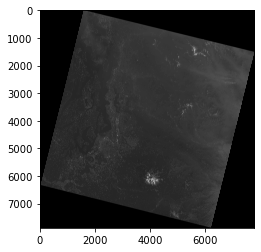

# Part 2: Histograms, NoData and Masked Arrays

## Create a histogram plot of DN (digital number) values in your array
* Does the matplotlib `hist()` expect a 2D array or a 1D array?
    * Maybe consider the NumPy `ravel` function here
* Make sure you use enough bins!  Try at least ~200.
* 🤔 Which bin has the highest count of pixels?
* 🤔 Over what range do most of the image DN values fall?
    * Is this consistent with the 12-bit sensor bit depth and 16-bit integer datatype (should have 2^16 possible values)?

## Let's get rid of that black border (nodata values)
* Unlike most raster data, the Landsat-8 images stored on the Google Cloud do not have a `nodata` value set in the image metadata
* As a result, when we read the raster to a NumPy array, the 0 values around the margins are consider valid pixels, and these appear black in our grayscale color ramp
* We have two options (read through both before starting):
    1. Set values of 0 to `np.nan`
        * Remember that `np.nan` is a special `float` object, so for this approach, you must first convert the entire array using `astype(float)`
            * This means we unnecessarily increase the amount of RAM required to store the same `UInt16` (2 byte) image DN values by a factor of 2x or 4x, as each `float32` value occupies 4 bytes, and the default NumPy `float` is actually `float64` or 8 bytes!  This increased memory requirement can be a real issue for large arrays. 
            * For this reason, I typically prefer to work with masked arrays (Option 2) for rasters with nodata.
        * Note that there are a growing number of "nan-aware" functions in NumPy (e.g., np.nanpercentile), but the options are still limited
        * Note that Pandas and xarray don't currently support masked ararys, but use `np.nan` for missing values
    2. Use a NumPy masked array (should be simple one-liner)
        * Take a few minutes to read about masked arrays
            * https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html#what-is-a-masked-array
            * https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html
            * Masked arrays allow for masking invalid values on any datatype (like `Byte` or `UInt16`)
                * Stores the mask as an additoinal 1-bit boolean array
        * See the `masked_equal` function to create a masked array from an existing array 
    * Note that you can also directly read a rasterio dataset to a NumPy masked array with the `masked=True` argument of the `read()` function (e.g., `a = src.read(1, masked=True)`)
        * More info on rasterio nodata handling and more advanced masking support: https://rasterio.readthedocs.io/en/latest/topics/masks.html
* Preview your new array, inspect the mask
* Try plotting the masked array with imshow using the `gray` cmap
    * You should no longer see a black border around the valid pixels

## Replot the histogram of your masked array
* Remember to covert your 2D masked array to 1D before running `hist()`
* There should no longer be a spike for the 0 bin

## Print the min and max values of masked array

## Determine the pixel DN value representing the 2nd and 98th percentile
* Note that if you're using a masked array, you will need to isolate unmasked values using the `compressed()` method of your masked array, then pass to the `np.percentile` function
* Plot these as vertical dotted black lines on your histogram
    * Hopefully this helps visualize what these percentile values represent based on your distribution.

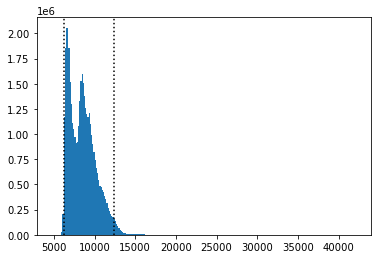

# Part 3: Raster transform
* Inspect the dataset `transform` attribute
* Review this: https://rasterio.readthedocs.io/en/stable/topics/georeferencing.html?highlight=affine#coordinate-transformation

## In your own words, what does this thing do?

## Use the transform to calculate the projected coordinates of the array corners
* Use the rasterio dataset `bounds` attribute to get the "truth" (you already did this)
* Creating tuples of array corner pixel coordinates (e.g. `(0,0), (array.shape[1], 0), ...`)
    * Useful to think of corners as upper left, upper right, lower right, lower left
    * *Careful about mixing (rows, columns) and (x, y) coordinates!*
    * I recommend you draw a quick sketch for this exercise
* Use the affine transformation to convert to projected coordinates
    * This should be pretty easy to do - can directly multiply the Affine transform by the (x,y) coordinate tuple
* What are the total dimensions of the projected image in km?
    * Sanity check! Remember your approximate LS-8 image footprint dimensions in km - make sure your calculated values are somewhat consistent!

array([[   0,    0],
       [   0, 7881],
       [7781,    0],
       [7781, 7881]])

array([[ 473385., 5373315.],
       [ 473385., 5136885.],
       [ 706815., 5373315.],
       [ 706815., 5136885.]])

I'm leaving in these sample coordinates as arrays, but you can work with each corner individually

## Determine the array indices (row, column) of the center pixel in the image
* Try to use array attributes (like `shape`) here, instead of hardcoding values
* Note that we have an odd number of rows and columns in this array, so the actual center indices may not be integers!

## Determine the DN value at this center pixel using array indexing
* Don't overthink this, just extract a value from the numpy array for the (row, col) indices you determined
* Make sure you are using integer values here (may need to convert/round), or NumPy will return an `IndexError`
* Do a sanity check on your interactive `imshow` plot above for DN values near the center of the image

## Determine the projected coordinates (meters in UTM 10N) of the center pixel
* Review the rasterio dataset `xy` method: https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.TransformMethodsMixin.xy
    * Careful about the order of your row and column indices
* Sanity check the resulting projected coordinates with rasterio dataset `index` method - this should return your (row, col) indices
    * https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.TransformMethodsMixin.index
    * These may be rounded to nearest integer
* These two functions allow you to go back and forth between the image/array coordiantes and the projected coordinate system!

## Extra Credit: sample the rasterio dataset (exctract the DN value) for these projected coordinates
* See https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html
* Note that this will return an iterable generator, so will need to evaluate (can encompass in `list()` operator)
* The resulting DN value should be similar to the value you extracted directly from the array

## Now, apply what you've learned!
What is the DN value at the following projected coordinates:
* (522785.0, 5323315.0)
* (`src.bounds.left + 50000`, `src.bounds.top - 50000`)

522785.0 5323315.0
1666 1646


6843

# Part 4: Visualization with projected coordinates and scalebar

## Extract the full-image `extent` in projected coordinates to pass to matplotlib imshow
* See doc on imshow `extent` parameter here: https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html
* Note that the matplotlib `extent` is similar to the rasterio `bounds`, but not identical!
    * Be careful about ordering of (left, bottom, right, top) vs. (min_x, max_x, min_y, max_y)!
    * There is also a convenience function to get the matplotlib `extent` for a rasterio Dataset: https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.plotting_extent

In [107]:
#This is rasterio bounds
src.bounds

BoundingBox(left=473385.0, bottom=5136885.0, right=706815.0, top=5373315.0)

In [108]:
#This is matplotlib extent
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[473385.0, 706815.0, 5136885.0, 5373315.0]


In [109]:
#rasterio convenience function
full_extent = rio.plot.plotting_extent(src)
print(full_extent)

(473385.0, 706815.0, 5136885.0, 5373315.0)


## Plot the image with `imshow`, but now pass in this `extent` as an argument
* Note how the axes coordinates change
    * These should now be meters in the UTM 10N coordinate system of the projected image!

## Add a dynamic scalebar to the above plot
* We will use the `matplotlib-scalebar` package for this
* See documentation: https://github.com/ppinard/matplotlib-scalebar
> The constructor arguments dx and units specify the pixel dimension. For example scalebar = ScaleBar(0.2, 'um') indicates that each pixel is equal to 0.2 micrometer. If the the axes image has already been calibrated by setting its extent, set dx to 1.0.
    * In other words:
        * For imshow using array coordinates (without defining `extent`), use `ax.add_artist(ScaleBar(res))` where res is the pixel resolution in meters
        * For imshow using projected coordinates with `extent` defined, use `ax.add_artist(ScaleBar(1.0))` because one unit in the axes coordinate system is equal to 1 m
* If using interactive matplotlib backend, note what happens to the scalebar when you zoom

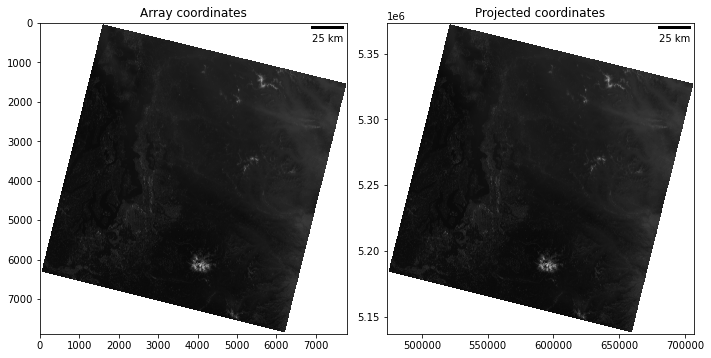

# Part 5: Raster window extraction

## Review: array indexing
* We could continue our analysis with the full images, but often we only care about a small subset of an image
* It's also a good practice to prototype new workflows using a small subset of data (faster processing, less memory usage).
    * Remember this for your project!  
* One way to accomplish this might be to extract a portion of the large array using slicing/indexing (see the Lab03 NumPy section)
    * Maybe a good time to review https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
* To extract a 1024x1024 px chunk of the full-size array, we could do something like:

In [112]:
r_masked.shape

(7881, 7781)

In [113]:
chunk = r_masked[3000:4024,3000:4024]

In [114]:
chunk.shape

(1024, 1024)

### Extra Credit: extract a 256x256 pixel window around the center pixel of the array
* You already determined the center pixel indices earlier
* You'll need to define the appropriate slices for both rows and columns
    * Try to define window dimensions and corresponding slices using variables, rather than hardcoding 256 or 128
* Preview the resulting 256x256 pixel array

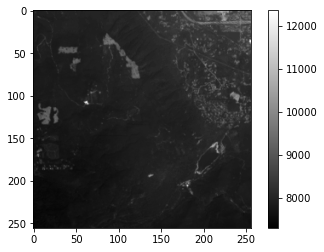

## Nice Job. Proceed to Part 2 Notebook!
* We'll pick up with rasterio `window` functionality to extract windows directly from the original tif files, then do all kinds of cool stuff with the resulting arrays